In [13]:
from pandas import Series
series = Series.from_csv('MadhyaPradeshRainfallData.csv') #, header=0)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 1368, Validation 12


In [2]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=1.600, Expected=  3
>Predicted=3.200, Expected=  1
>Predicted=1.300, Expected=  1
>Predicted=1.400, Expected=  3
>Predicted=3.200, Expected=  1
>Predicted=0.900, Expected= 82
>Predicted=82.500, Expected=384
>Predicted=383.600, Expected=284
>Predicted=284.000, Expected=271
>Predicted=271.100, Expected= 58
>Predicted=57.700, Expected= 10
>Predicted=10.100, Expected=  1
>Predicted=0.700, Expected= 23
>Predicted=23.000, Expected=  0
>Predicted=0.100, Expected=  0
>Predicted=0.200, Expected=  4
>Predicted=4.000, Expected= 22
>Predicted=22.000, Expected= 79
>Predicted=78.900, Expected=396
>Predicted=395.500, Expected=326
>Predicted=325.800, Expected=254
>Predicted=254.300, Expected= 71
>Predicted=70.700, Expected=  7
>Predicted=7.000, Expected=  0
>Predicted=0.100, Expected= 25
>Predicted=25.200, Expected=  0
>Predicted=0.100, Expected= 12
>Predicted=12.400, Expected=  1
>Predicted=1.400, Expected=  7
>Predicted=6.600, Expected=132
>Predicted=132.500, Expected=203
>Predicted=203.2

In [3]:
from pandas import Series
series = Series.from_csv('dataset.csv')
print(series.describe())

count    1367.000000
mean       78.430066
std       120.592759
min         0.100000
25%         1.300000
50%         9.500000
75%       123.350000
max       561.600000
dtype: float64


# Line Plot

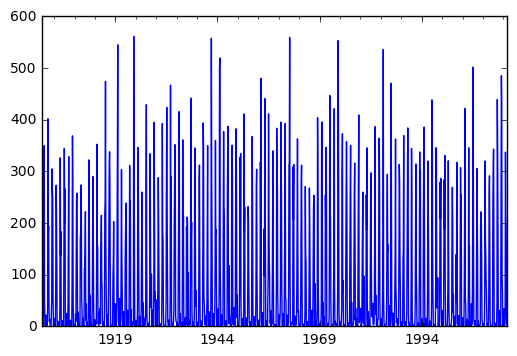

In [4]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
series.plot()
pyplot.show()

# Seasonal Line Plots

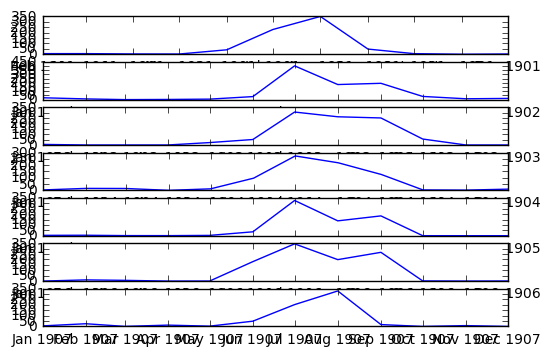

In [5]:
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot
%matplotlib inline
series = Series.from_csv('dataset.csv')
groups = series['1901':'1907'].groupby(TimeGrouper('A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
    pyplot.subplot((n_groups*100) + 10 + i)
    i += 1
    pyplot.plot(group)
pyplot.show()

# Density Plot

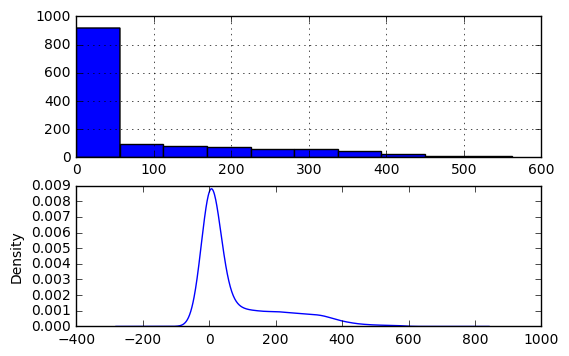

In [6]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

# Box and Whisker Plots

C:\Users\SakSar\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


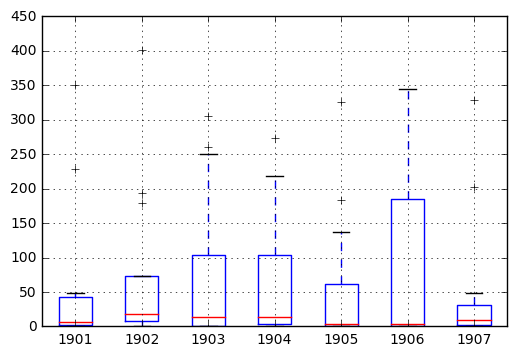

In [14]:
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
groups = series['1901':'1907'].groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

## ARIMA Models


In this section, we will develop Autoregressive Integrated Moving Average, or ARIMA, models for the problem.

We will approach modeling by both manual and automatic configuration of the ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

As such, this section is broken down into 3 steps:

Manually Configure the ARIMA.
Automatically Configure the ARIMA.
Review Residual Errors.

ADF Statistic: -16.603484
p-value: 0.000000
Critical Values:
	1%: -3.435
	10%: -2.568
	5%: -2.864


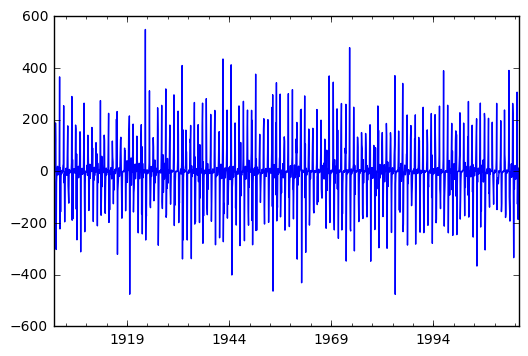

In [17]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

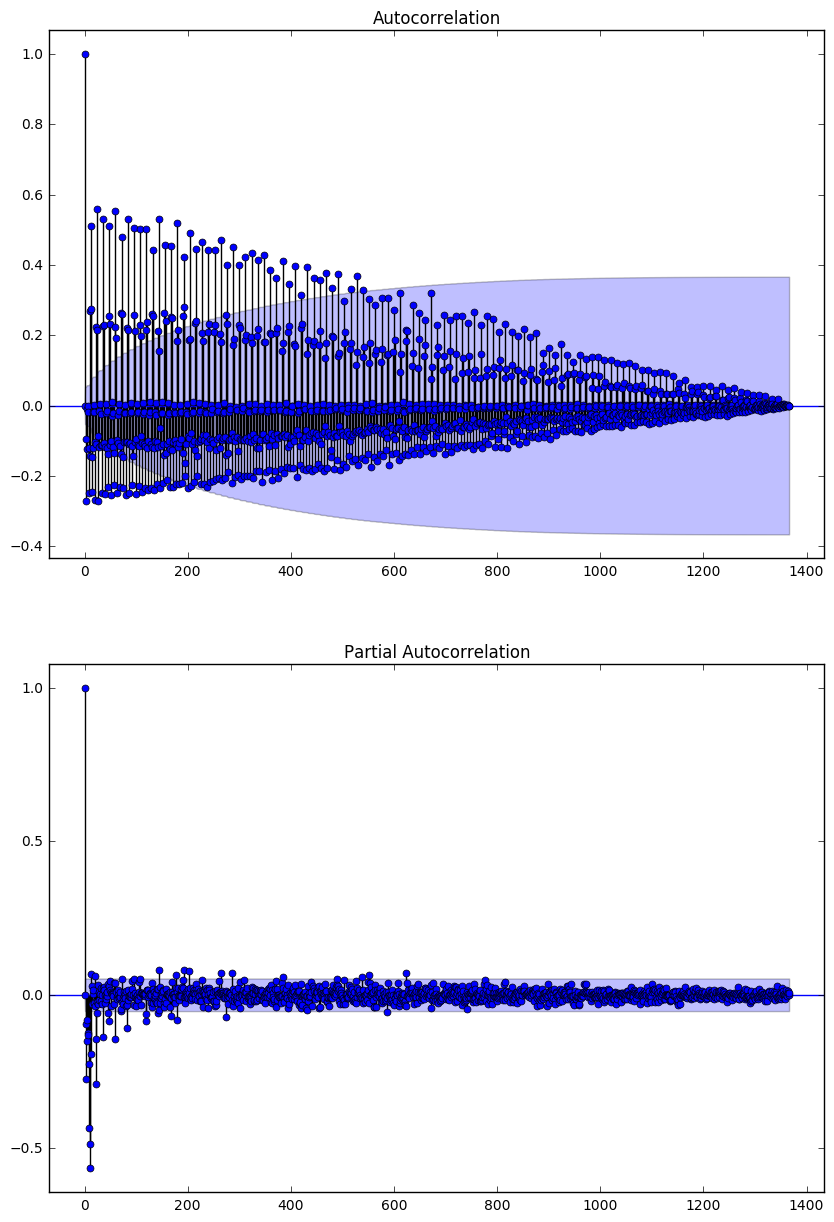

In [20]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Series.from_csv('stationary.csv')
#pyplot.figure()
figure = pyplot.figure(figsize=(10,15))                 #pyplot.rcParams['figure.figsize'][0],pyplot.rcParams['figure.figsize'][0] * 0.975))
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

In [8]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=12.976, Expected=  3
>Predicted=0.929, Expected=  1
>Predicted=30.486, Expected=  1
>Predicted=7.783, Expected=  3
>Predicted=4.293, Expected=  1
>Predicted=89.635, Expected= 82
>Predicted=223.787, Expected=384
>Predicted=328.831, Expected=284
>Predicted=117.034, Expected=271
>Predicted=1.115, Expected= 58
>Predicted=-1.527, Expected= 10
>Predicted=1.548, Expected=  1
>Predicted=3.863, Expected= 23
>Predicted=0.486, Expected=  0
>Predicted=2.112, Expected=  0
>Predicted=3.911, Expected=  4
>Predicted=1.466, Expected= 22
>Predicted=81.618, Expected= 79
>Predicted=384.509, Expected=396
>Predicted=283.800, Expected=326
>Predicted=268.788, Expected=254
>Predicted=59.624, Expected= 71
>Predicted=9.876, Expected=  7
>Predicted=1.642, Expected=  0
>Predicted=23.759, Expected= 25
>Predicted=0.657, Expected=  0
>Predicted=0.916, Expected= 12
>Predicted=3.844, Expected=  1
>Predicted=22.917, Expected=  7
>Predicted=80.728, Expected=132
>Predicted=392.365, Expected=203
>Predicted=340.8

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.577, Expected=  1
>Predicted=6.885, Expected=  7
>Predicted=132.705, Expected= 74
>Predicted=207.996, Expected=311


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=384.446, Expected=319
>Predicted=59.913, Expected=559
>Predicted=7.821, Expected=128
>Predicted=-4.755, Expected=  8
>Predicted=1.928, Expected=  1
>Predicted=23.086, Expected=  7
>Predicted=4.035, Expected=  5
>Predicted=1.311, Expected=  8
>Predicted=1.192, Expected=  8
>Predicted=7.371, Expected=  4
>Predicted=75.280, Expected= 16
>Predicted=316.746, Expected=309
>Predicted=319.979, Expected=207
>Predicted=568.857, Expected=313
>Predicted=146.390, Expected=  0
>Predicted=16.636, Expected=  8
>Predicted=1.563, Expected= 20
>Predicted=5.783, Expected=  6
>Predicted=5.207, Expected=  6
>Predicted=8.035, Expected=  2
>Predicted=8.996, Expected=  3
>Predicted=4.694, Expected=  4
>Predicted=16.668, Expected= 71


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=305.615, Expected=235
>Predicted=211.887, Expected=363
>Predicted=303.469, Expected=155
>Predicted=11.523, Expected= 27
>Predicted=6.569, Expected= 31
>Predicted=18.994, Expected=  2
>Predicted=7.661, Expected=  0
>Predicted=6.191, Expected=  0


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.139, Expected=  2
>Predicted=3.274, Expected=  0
>Predicted=4.355, Expected=  8
>Predicted=70.981, Expected=112
>Predicted=232.604, Expected=279
>Predicted=360.373, Expected=312
>Predicted=159.332, Expected=163


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=26.550, Expected=  3
>Predicted=32.592, Expected=  0
>Predicted=4.611, Expected=  1
>Predicted=0.404, Expected=  5
>Predicted=0.001, Expected=  1
>Predicted=2.394, Expected=  2
>Predicted=0.379, Expected=  2
>Predicted=7.803, Expected=  1
>Predicted=112.434, Expected= 31
>Predicted=284.655, Expected=271
>Predicted=312.878, Expected=142
>Predicted=175.157, Expected=124
>Predicted=5.328, Expected=  6
>Predicted=-0.295, Expected=  1
>Predicted=0.954, Expected= 10
>Predicted=4.050, Expected=  4
>Predicted=0.582, Expected=  1
>Predicted=1.414, Expected=  2
>Predicted=1.788, Expected=  0
>Predicted=0.557, Expected=  3
>Predicted=30.779, Expected= 69
>Predicted=268.062, Expected=268
>Predicted=142.588, Expected=201
>Predicted=119.961, Expected=104
>Predicted=7.206, Expected=  1
>Predicted=1.291, Expected= 24
>Predicted=7.982, Expected=  4
>Predicted=4.326, Expected=  0
>Predicted=1.112, Expected=  0
>Predicted=2.197, Expected= 32
>Predicted=-1.968, Expected=  2
>Predicted=2.617, Ex

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=126.236, Expected= 34
>Predicted=229.931, Expected=404
>Predicted=241.229, Expected=292
>Predicted=219.976, Expected= 94
>Predicted=11.674, Expected= 14
>Predicted=-0.426, Expected=  0
>Predicted=82.800, Expected=  0
>Predicted=15.223, Expected=  6
>Predicted=2.441, Expected=  0
>Predicted=10.004, Expected=  0
>Predicted=2.051, Expected=  0
>Predicted=0.441, Expected=  1
>Predicted=34.527, Expected= 48
>Predicted=403.331, Expected=393
>Predicted=292.830, Expected=396
>Predicted=87.014, Expected=226
>Predicted=5.564, Expected=  0
>Predicted=1.508, Expected= 46
>Predicted=-2.199, Expected=  0
>Predicted=6.226, Expected= 20
>Predicted=-0.130, Expected= 12
>Predicted=-0.152, Expected=  8
>Predicted=0.204, Expected=  0
>Predicted=1.344, Expected= 12
>Predicted=47.701, Expected=254
>Predicted=380.248, Expected=186
>Predicted=412.212, Expected=347
>Predicted=230.647, Expected=266
>Predicted=-2.225, Expected=  7
>Predicted=45.877, Expected=  0
>Predicted=4.179, Expected=  0
>Predict

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.627, Expected=  0
>Predicted=5.938, Expected=  0
>Predicted=2.963, Expected=  4
>Predicted=1.594, Expected=  0
>Predicted=3.420, Expected=  0
>Predicted=18.447, Expected=  2
>Predicted=185.695, Expected= 92
>Predicted=454.764, Expected=162
>Predicted=241.974, Expected=421
>Predicted=192.611, Expected= 74
>Predicted=57.955, Expected=  4
>Predicted=3.992, Expected= 10
>Predicted=-0.715, Expected=  1
>Predicted=0.076, Expected=  0
>Predicted=3.767, Expected=  5
>Predicted=0.035, Expected=  0
>Predicted=0.168, Expected=  0
>Predicted=1.951, Expected=  3
>Predicted=92.007, Expected= 74
>Predicted=163.155, Expected=553
>Predicted=386.321, Expected=479
>Predicted=70.154, Expected=257
>Predicted=-10.169, Expected= 26
>Predicted=9.152, Expected=  0
>Predicted=2.748, Expected= 10
>Predicted=0.262, Expected=  0
>Predicted=6.052, Expected=  1
>Predicted=1.325, Expected=  0
>Predicted=1.138, Expected=  1
>Predicted=3.421, Expected= 15
>Predicted=73.900, Expected= 41
>Predicted=556.602,

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=110.657, Expected=254
>Predicted=186.105, Expected=187
>Predicted=260.735, Expected=346
>Predicted=29.341, Expected= 50
>Predicted=5.315, Expected=  3
>Predicted=98.136, Expected=  2
>Predicted=9.403, Expected= 29
>Predicted=-1.183, Expected=  4
>Predicted=0.614, Expected=  0
>Predicted=0.699, Expected= 10
>Predicted=-0.259, Expected=  0
>Predicted=1.096, Expected= 11
>Predicted=253.938, Expected=118
>Predicted=196.097, Expected=269
>Predicted=340.145, Expected=297
>Predicted=53.788, Expected=122
>Predicted=-1.547, Expected= 21


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.766, Expected= 19
>Predicted=27.883, Expected= 18
>Predicted=5.232, Expected= 45
>Predicted=-2.223, Expected=  5
>Predicted=10.035, Expected=  3
>Predicted=0.820, Expected=  3
>Predicted=10.753, Expected=  8
>Predicted=118.503, Expected= 62
>Predicted=272.865, Expected=247
>Predicted=298.862, Expected=387
>Predicted=116.424, Expected= 89
>Predicted=23.162, Expected= 23
>Predicted=19.122, Expected= 60
>Predicted=15.750, Expected=  2
>Predicted=46.174, Expected=  5
>Predicted=7.737, Expected=  1
>Predicted=3.683, Expected=  0
>Predicted=3.106, Expected= 14
>Predicted=7.717, Expected= 14
>Predicted=61.305, Expected= 88
>Predicted=245.531, Expected=238
>Predicted=387.559, Expected=364
>Predicted=91.081, Expected=292
>Predicted=9.214, Expected= 55
>Predicted=58.202, Expected=  0
>Predicted=7.003, Expected=  1
>Predicted=5.281, Expected= 15
>Predicted=0.264, Expected=  6
>Predicted=0.114, Expected=  0
>Predicted=14.101, Expected=  0


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=15.243, Expected=  0
>Predicted=89.642, Expected= 64
>Predicted=240.287, Expected=165
>Predicted=369.763, Expected=536
>Predicted=279.589, Expected= 60
>Predicted=73.573, Expected= 12
>Predicted=3.526, Expected=  0
>Predicted=1.257, Expected=  0
>Predicted=15.399, Expected=  2
>Predicted=7.237, Expected=  0
>Predicted=0.690, Expected=  0
>Predicted=0.225, Expected=  4
>Predicted=-0.098, Expected=  4
>Predicted=63.329, Expected= 55
>Predicted=166.049, Expected=212
>Predicted=532.646, Expected=294
>Predicted=79.096, Expected=144
>Predicted=5.732, Expected=158
>Predicted=-11.167, Expected=  0
>Predicted=0.657, Expected=  0
>Predicted=2.299, Expected= 10
>Predicted=-0.304, Expected= 40


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-2.746, Expected=  2
>Predicted=4.538, Expected=  0
>Predicted=4.753, Expected=  5
>Predicted=55.531, Expected=130
>Predicted=206.172, Expected=471
>Predicted=275.567, Expected=238
>Predicted=149.248, Expected= 33
>Predicted=166.572, Expected=  6
>Predicted=11.300, Expected=  0
>Predicted=0.340, Expected=  1
>Predicted=9.651, Expected= 26
>Predicted=39.578, Expected= 13
>Predicted=4.689, Expected=  1
>Predicted=0.555, Expected=  0
>Predicted=5.523, Expected=  7
>Predicted=129.887, Expected= 74
>Predicted=474.768, Expected=144
>Predicted=259.862, Expected=363
>Predicted=24.022, Expected= 78
>Predicted=3.227, Expected= 55
>Predicted=-3.415, Expected=  8
>Predicted=0.666, Expected= 15
>Predicted=24.738, Expected=  4
>Predicted=14.868, Expected=  1
>Predicted=1.555, Expected=  2
>Predicted=0.018, Expected=  5
>Predicted=6.774, Expected=  5
>Predicted=74.512, Expected=136
>Predicted=139.790, Expected=314
>Predicted=350.885, Expected=279
>Predicted=84.023, Expected=146
>Predicted=

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=15.432, Expected= 15
>Predicted=5.843, Expected=  1
>Predicted=0.970, Expected= 16
>Predicted=4.843, Expected=  1
>Predicted=2.043, Expected=  1
>Predicted=221.548, Expected= 67
>Predicted=364.297, Expected=320
>Predicted=388.402, Expected=252
>Predicted=196.750, Expected=164
>Predicted=4.371, Expected= 20


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.851, Expected=  0
>Predicted=0.426, Expected=  8
>Predicted=14.281, Expected= 10
>Predicted=1.241, Expected=  5
>Predicted=15.467, Expected=  2
>Predicted=2.460, Expected=  0
>Predicted=1.495, Expected=  1
>Predicted=67.318, Expected= 49
>Predicted=321.604, Expected=438


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=244.029, Expected=366
>Predicted=156.168, Expected=155
>Predicted=20.514, Expected= 57
>Predicted=-2.109, Expected=  1
>Predicted=8.382, Expected=  0
>Predicted=11.188, Expected=  3
>Predicted=5.534, Expected=  0
>Predicted=2.845, Expected=  1
>Predicted=0.833, Expected=  4
>Predicted=1.490, Expected=  2
>Predicted=48.913, Expected= 90
>Predicted=436.081, Expected=346
>Predicted=372.923, Expected=335
>Predicted=157.101, Expected= 97
>Predicted=61.393, Expected= 36
>Predicted=2.715, Expected= 51
>Predicted=-3.069, Expected= 94


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-2.956, Expected=  2
>Predicted=0.443, Expected=  1
>Predicted=0.981, Expected=  9
>Predicted=3.775, Expected=  2
>Predicted=2.160, Expected=  1
>Predicted=90.092, Expected= 93
>Predicted=346.008, Expected=279
>Predicted=339.527, Expected=208
>Predicted=105.617, Expected=287
>Predicted=23.371, Expected= 39
>Predicted=51.503, Expected=  6
>Predicted=97.260, Expected=  0
>Predicted=9.056, Expected=  1
>Predicted=0.904, Expected= 31
>Predicted=7.059, Expected=  0
>Predicted=2.704, Expected=  0
>Predicted=0.930, Expected=  4
>Predicted=92.847, Expected=127
>Predicted=276.932, Expected=284
>Predicted=208.306, Expected=188
>Predicted=288.209, Expected=331
>Predicted=36.370, Expected= 86
>Predicted=3.528, Expected=  0
>Predicted=0.814, Expected=  0
>Predicted=1.205, Expected=  0
>Predicted=31.357, Expected=  0
>Predicted=2.461, Expected=  0
>Predicted=0.376, Expected=  0
>Predicted=4.774, Expected= 30
>Predicted=125.569, Expected= 93
>Predicted=286.538, Expected=320
>Predicted=185.

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.928, Expected=  1
>Predicted=1.964, Expected=  0
>Predicted=11.676, Expected=  0
>Predicted=3.561, Expected=  2
>Predicted=0.672, Expected=  2
>Predicted=14.516, Expected=  4
>Predicted=100.805, Expected=194
>Predicted=298.299, Expected=222
>Predicted=227.349, Expected=206
>Predicted=139.534, Expected=140
>Predicted=0.043, Expected= 13
>Predicted=9.546, Expected=  8
>Predicted=0.900, Expected=  0
>Predicted=0.501, Expected=  6
>Predicted=-0.240, Expected=  0
>Predicted=2.565, Expected=  0
>Predicted=2.754, Expected=  1
>Predicted=3.958, Expected=  6
>Predicted=194.050, Expected= 57
>Predicted=232.696, Expected=320
>Predicted=197.799, Expected=173
>Predicted=142.397, Expected=140
>Predicted=12.914, Expected= 90
>Predicted=1.289, Expected= 65
>Predicted=-4.449, Expected= 19
>Predicted=4.095, Expected=  2
>Predicted=0.495, Expected=  5
>Predicted=-0.194, Expected=  1
>Predicted=1.378, Expected=  0
>Predicted=6.730, Expected=  0
>Predicted=57.421, Expected= 62
>Predicted=319.9

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=338.021, Expected=433
>Predicted=187.628, Expected= 99
>Predicted=10.241, Expected= 69
>Predicted=-4.743, Expected=  0
>Predicted=0.624, Expected=  2
>Predicted=2.059, Expected= 26
>Predicted=29.730, Expected= 34
>Predicted=8.798, Expected=  5
>Predicted=3.678, Expected=  1
>Predicted=1.075, Expected=  1
>Predicted=264.181, Expected= 31
>Predicted=504.339, Expected=337
>Predicted=444.068, Expected=211
>Predicted=114.776, Expected=193
>Predicted=61.975, Expected=  7
>Predicted=4.974, Expected=  3
>Predicted=2.308, Expected= 16
RMSE: 73.957


# testing diff models

In [33]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=32.708, Expected=  3
>Predicted=-19.059, Expected=  1
>Predicted=47.756, Expected=  1
>Predicted=6.752, Expected=  3
>Predicted=2.891, Expected=  1
>Predicted=89.869, Expected= 82
>Predicted=241.628, Expected=384
>Predicted=327.742, Expected=284
>Predicted=123.081, Expected=271
>Predicted=-6.561, Expected= 58
>Predicted=5.314, Expected= 10
>Predicted=5.898, Expected=  1
>Predicted=-0.103, Expected= 23
>Predicted=5.033, Expected=  0
>Predicted=6.375, Expected=  0
>Predicted=2.863, Expected=  4
>Predicted=0.752, Expected= 22
>Predicted=81.952, Expected= 79
>Predicted=384.998, Expected=396
>Predicted=282.241, Expected=326
>Predicted=268.789, Expected=254
>Predicted=61.410, Expected= 71
>Predicted=7.129, Expected=  7
>Predicted=2.065, Expected=  0
>Predicted=24.629, Expected= 25
>Predicted=-0.445, Expected=  0
>Predicted=0.616, Expected= 12
>Predicted=3.201, Expected=  1
>Predicted=22.604, Expected=  7
>Predicted=79.585, Expected=132
>Predicted=391.091, Expected=203


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=341.696, Expected=393
>Predicted=238.705, Expected= 54
>Predicted=94.381, Expected= 53
>Predicted=-0.835, Expected=  0
>Predicted=-3.017, Expected=  2
>Predicted=27.980, Expected= 22
>Predicted=-6.584, Expected=  2
>Predicted=8.722, Expected=  0
>Predicted=2.834, Expected=  1
>Predicted=5.731, Expected=  7
>Predicted=132.744, Expected= 74
>Predicted=207.668, Expected=311
>Predicted=381.016, Expected=319
>Predicted=66.962, Expected=559
>Predicted=2.490, Expected=128
>Predicted=27.701, Expected=  8
>Predicted=-5.522, Expected=  1
>Predicted=11.638, Expected=  7
>Predicted=25.704, Expected=  5
>Predicted=7.770, Expected=  8
>Predicted=0.262, Expected=  8
>Predicted=7.317, Expected=  4
>Predicted=73.664, Expected= 16
>Predicted=314.845, Expected=309
>Predicted=315.553, Expected=207
>Predicted=569.334, Expected=313
>Predicted=137.414, Expected=  0
>Predicted=-31.604, Expected=  8
>Predicted=34.707, Expected= 20
>Predicted=-25.126, Expected=  6
>Predicted=37.519, Expected=  6
>Pre

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=87.070, Expected=226
>Predicted=21.024, Expected=  0
>Predicted=-0.675, Expected= 46
>Predicted=3.486, Expected=  0
>Predicted=1.242, Expected= 20
>Predicted=6.566, Expected= 12
>Predicted=-11.094, Expected=  8
>Predicted=13.367, Expected=  0
>Predicted=-13.341, Expected= 12
>Predicted=62.351, Expected=254
>Predicted=378.624, Expected=186
>Predicted=414.569, Expected=347
>Predicted=217.203, Expected=266
>Predicted=-4.413, Expected=  7
>Predicted=56.073, Expected=  0
>Predicted=-16.674, Expected=  0
>Predicted=42.037, Expected=  5
>Predicted=-9.536, Expected=  2


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=29.719, Expected=  1
>Predicted=-22.447, Expected=  3
>Predicted=36.327, Expected= 18
>Predicted=229.920, Expected=184
>Predicted=211.975, Expected=447
>Predicted=319.047, Expected=220
>Predicted=291.017, Expected=210
>Predicted=-3.133, Expected= 46
>Predicted=-1.100, Expected=  0
>Predicted=7.160, Expected=  0
>Predicted=-9.993, Expected=  0
>Predicted=20.137, Expected=  4
>Predicted=-14.294, Expected=  0
>Predicted=16.734, Expected=  0
>Predicted=3.988, Expected=  2
>Predicted=197.687, Expected= 92
>Predicted=434.732, Expected=162
>Predicted=235.190, Expected=421
>Predicted=190.827, Expected= 74
>Predicted=53.561, Expected=  4
>Predicted=8.303, Expected= 10
>Predicted=-17.701, Expected=  1
>Predicted=29.802, Expected=  0
>Predicted=-34.437, Expected=  5
>Predicted=42.103, Expected=  0
>Predicted=-39.947, Expected=  0
>Predicted=41.400, Expected=  3
>Predicted=52.670, Expected= 74
>Predicted=201.089, Expected=553
>Predicted=372.055, Expected=479
>Predicted=113.110, Expected

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=23.087, Expected=  1
>Predicted=96.531, Expected=254
>Predicted=209.367, Expected=187
>Predicted=249.241, Expected=346
>Predicted=54.828, Expected= 50
>Predicted=-15.017, Expected=  3
>Predicted=126.573, Expected=  2
>Predicted=-30.699, Expected= 29
>Predicted=32.388, Expected=  4
>Predicted=-39.797, Expected=  0
>Predicted=40.438, Expected= 10
>Predicted=-39.367, Expected=  0
>Predicted=43.202, Expected= 11
>Predicted=212.544, Expected=118
>Predicted=231.481, Expected=269
>Predicted=295.797, Expected=297
>Predicted=92.387, Expected=122
>Predicted=-32.637, Expected= 21
>Predicted=30.416, Expected= 19
>Predicted=12.255, Expected= 18
>Predicted=17.525, Expected= 45
>Predicted=-13.617, Expected=  5
>Predicted=18.256, Expected=  3
>Predicted=-4.927, Expected=  3
>Predicted=14.252, Expected=  8
>Predicted=114.964, Expected= 62
>Predicted=274.957, Expected=247
>Predicted=292.684, Expected=387
>Predicted=120.099, Expected= 89
>Predicted=24.412, Expected= 23
>Predicted=20.633, Expec

# 6.2 Grid Search ARIMA Hyperparameters

In [ ]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
#p_values = range(0, 7)
p_values = range(6, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(6, 0, 0) RMSE=73.842


# 6.3 Review Residual Errors

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                0
count  684.000000
mean    -0.004543
std     71.956068
min   -309.147570
25%    -21.254342
50%      0.175873
75%     21.433139
max    492.438045


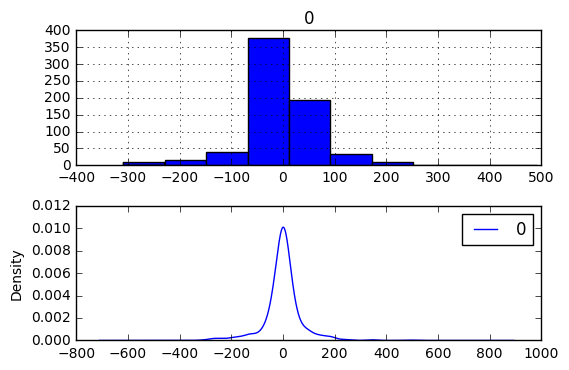

In [13]:
from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

correcting the value by using the mean value

In [ ]:
from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt



# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -0.004543
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data.

The example below re-calculates the residual errors and creates ACF and PACF plots to check for any significant autocorrelation.

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                0
count  684.000000
mean    -0.004543
std     71.956068
min   -309.147570
25%    -21.254342
50%      0.175873
75%     21.433139
max    492.438045


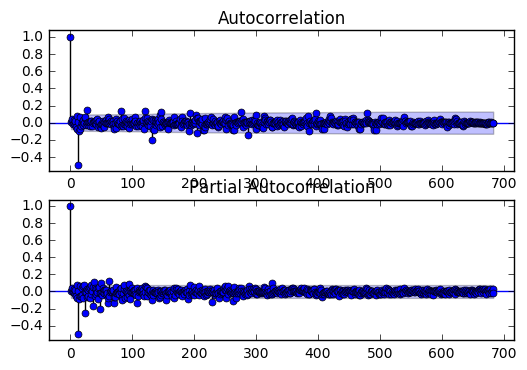

In [14]:
from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

# 7. Model Validation

In [37]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(6,1,5))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = -0.004543
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# 7.2 Make Prediction

In [38]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = Series.from_csv('dataset.csv')
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 55.058


# 7.3 Validate Model

>Predicted=55.058, Expected= 40


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.789, Expected=  6
>Predicted=33.889, Expected= 54


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-10.553, Expected= 13


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-6.844, Expected=  2


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=57.583, Expected=154


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=313.125, Expected=428


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=239.811, Expected=277


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=191.236, Expected= 56
>Predicted=7.358, Expected= 11
>Predicted=-31.100, Expected=  0
>Predicted=17.468, Expected=  1
RMSE: 61.137


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


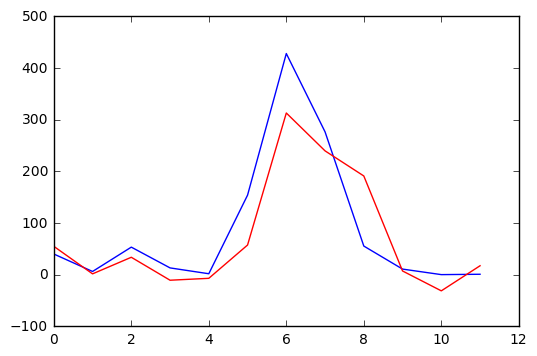

In [39]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(6,1,5))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

## next year prediction

In [11]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = Series.from_csv('MadhyaPradeshRainfallData.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(6,1,5))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = -0.004543
# save model
model_fit.save('model1.pkl')
numpy.save('model_bias1.npy', [bias])

C:\Users\shrutika\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [12]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = Series.from_csv('MadhyaPradeshRainfallData.csv')
months_in_year = 12
model_fit = ARIMAResults.load('model1.pkl')
bias = numpy.load('model_bias1.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 82.067


>Predicted=69.658, Expected=  4


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.808, Expected=  4


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-3.620, Expected= 11


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.480, Expected=  2


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.041, Expected= 19


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=153.514, Expected=137


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=383.009, Expected=383


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=286.078, Expected=321


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=94.804, Expected=195


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.288, Expected= 67


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-2.842, Expected=  2


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-1.342, Expected=  0
RMSE: 42.411


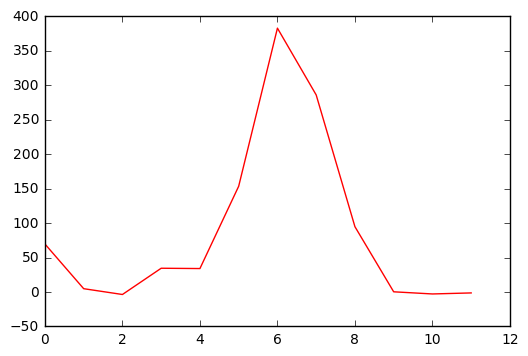

In [3]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('MadhyaPradeshRainfallData.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation1.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
#print('Predicted: %.3f' % yhat)
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, 12):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(6,1,5))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    #print('Predicted: %.3f' % yhat)
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
#pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

>Predicted=69.658, Expected=  4


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.808, Expected=  4


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-3.620, Expected= 11


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.480, Expected=  2


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.041, Expected= 19


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=153.514, Expected=137


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=383.009, Expected=383


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=286.078, Expected=321


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=94.804, Expected=195


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.288, Expected= 67


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-2.842, Expected=  2


C:\Users\SakSar\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=-1.342, Expected=  0
RMSE: 42.411


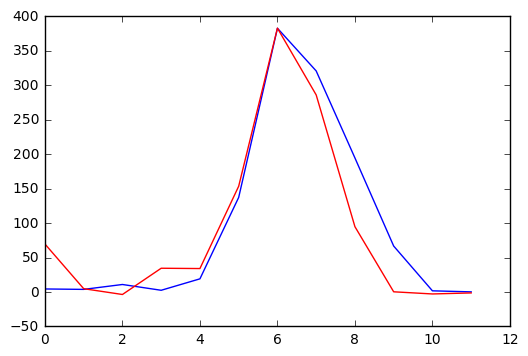

In [2]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('MadhyaPradeshRainfallData.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation1.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
#print('Predicted: %.3f' % yhat)
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, 12):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(6,1,5))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    #print('Predicted: %.3f' % yhat)
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()